In [1]:
import cadEditorPath
from cadEditorPath import cadEditorDir, picPath

import clr
clr.AddReference("CadEditor")
clr.AddReference("PluginVideoNes")

from PluginVideoNes import Video
from CadEditor import UtilsGDI
from System.Drawing import Bitmap
from System import Array, Byte
import array
from IPython.display import display, Image

In [2]:
romName = cadEditorDir + "/Addams Family, The (E) [!].nes"
with open(romName, "rb") as f:
    d = f.read()

In [3]:
video = Video()

In [4]:
def toDotNetArray(data):
    return  Array[Byte](array.array('B', data))

CHR_ADDR = 0x21010 #адрес банка видеопамяти для фона первого уровня
CHR_BANK_SIZE = 0x1000
chrData = d[CHR_ADDR:CHR_ADDR + CHR_BANK_SIZE]
chrData = toDotNetArray(chrData)

PAL_ADDR = 0x2e0d #адрес палитры
PAL_SIZE = 16
palData = d[PAL_ADDR:PAL_ADDR + PAL_SIZE]
palData = toDotNetArray(palData)

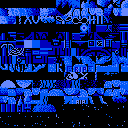

In [5]:
chrBitmap = video.makeImageRectangle(chrData, palData, 0, False)
picPath = "D:/CadEditorPythonExamples/"
#сохраняем картинку в файл:
chrBitmap.Save(picPath+"chr0.png")
#отображаем её:
Image(filename=picPath+"chr0.png")

Отображение игровых блоков
---

Палитры описываются одним байтом на блок 4x4 тайла, по 2 бита на квадрат из 2x2 тайлов, описание слева-направо

In [6]:
def readPalMatrix():
    PAL_ADDRESS = 0xCCCC
    PAL_ROW_LEN = 64
    PAL_HEIGHT = 8 #read 5 bytes for row and additional 3 bytes for floors
    pals = []
    for x in range(PAL_HEIGHT):
        rowBeginAddr = PAL_ADDRESS + x*PAL_ROW_LEN
        row = d[rowBeginAddr:rowBeginAddr+PAL_ROW_LEN]
        pals.append(row)
    #транспонируем строки и столбцы, чтобы экран описывался постолбцово, а не построчно, соотвественно тому, как описываются тайлы
    pals = [list(x) for x in zip(*pals)]
    return pals

palMatrix = readPalMatrix()

In [7]:
def makePalBitsForRow(pals, rowIndex):
    palBlocks = pals[int(rowIndex/4)]
    palBits = []
    #
    if (rowIndex%4 < 2):
        for palBlockIndex in range(len(palBlocks)):
            palBlock = palBlocks[palBlockIndex]
            palBits.append((palBlock>>0) & 0x3)
            palBits.append((palBlock>>0) & 0x3)
            palBits.append((palBlock>>4) & 0x3)
            palBits.append((palBlock>>4) & 0x3)
    else:
        for palBlockIndex in range(len(palBlocks)):
            palBlock = palBlocks[palBlockIndex]
            palBits.append((palBlock>>2) & 0x3)
            palBits.append((palBlock>>2) & 0x3)
            palBits.append((palBlock>>6) & 0x3)
            palBits.append((palBlock>>6) & 0x3)
    return palBits

Уровень описывается индексами строк тайлов. Строки состоят из 20 тайлов в высоту

In [8]:
def makeColumnTiles(addr, height):
    ts = []
    for x in range(height):
        tileIndex = d[addr+x]
        ts.append(tileIndex)
    return ts

In [9]:
def makeColumnImage(ts, palBits):
    ti = []
    for x in range(LEVEL_HEIGHT):
        t = video.makeImage(ts[x], chrData, palData, palBits[x], False)
        ti.append(t)
    return UtilsGDI.GlueImages(Array[Bitmap](ti),1,LEVEL_HEIGHT)

In [10]:
LINE_ADDR = 0xC282
LEVEL_HEIGHT = 20

FLOOR_ADDR = 0xCC34
FLOOR_HEIGHT = 6

LEVEL_WIDTH = 128
lineTiles = []
floorTiles = []
for l in range(LEVEL_WIDTH):
    lineTiles.append(makeColumnTiles(LINE_ADDR + l*LEVEL_HEIGHT, LEVEL_HEIGHT))
    floorTiles.append(makeColumnTiles(FLOOR_ADDR + l*FLOOR_HEIGHT, FLOOR_HEIGHT))

In [11]:
def makeColumnImage(ts, palBits, height):
    ti = []
    for x in range(height):
        t = video.makeImage(ts[x], chrData, palData, palBits[x], False)
        ti.append(t)
    return UtilsGDI.GlueImages(Array[Bitmap](ti), 1, height)

In [12]:
for x in range(3):
    im = makeColumnImage(lineTiles[x], [0]*LEVEL_HEIGHT, LEVEL_HEIGHT)
    im.Save(picPath+"line%d.png"%x)
    display(Image(filename=picPath+"line%d.png"%x))

In [13]:
for x in range(4):
    im = makeColumnImage(floorTiles[x], [0]*(FLOOR_HEIGHT), FLOOR_HEIGHT)
    im.Save(picPath+"floor%d.png"%x)
    display(Image(filename=picPath+"floor%d.png"%x))

In [14]:
def makeScreen():
    LINES_COUNT = 256
    
    LINES_INDEXES_ADDR = 0xC0A8
    indexes = d[LINES_INDEXES_ADDR:LINES_INDEXES_ADDR+LINES_COUNT]
    
    FLOOR_INDEXES_ADDR = 0xcb06
    findexes = d[FLOOR_INDEXES_ADDR:FLOOR_INDEXES_ADDR+LINES_COUNT]
    
    linesPics = []
    for x in range(LINES_COUNT):
        palBits = makePalBitsForRow(palMatrix,x)
        #lineImage = makeColumnImage([0x14]*20, palBits)
        lineImage = makeColumnImage(lineTiles[indexes[x]], palBits, LEVEL_HEIGHT)
        floorImage = makeColumnImage(floorTiles[findexes[x]], palBits[20:], FLOOR_HEIGHT)
        totalImage = UtilsGDI.GlueImages(Array[Bitmap]([lineImage, floorImage]), 1, 2)
        linesPics.append(totalImage)
    return UtilsGDI.GlueImages(Array[Bitmap](linesPics), LINES_COUNT, 1)

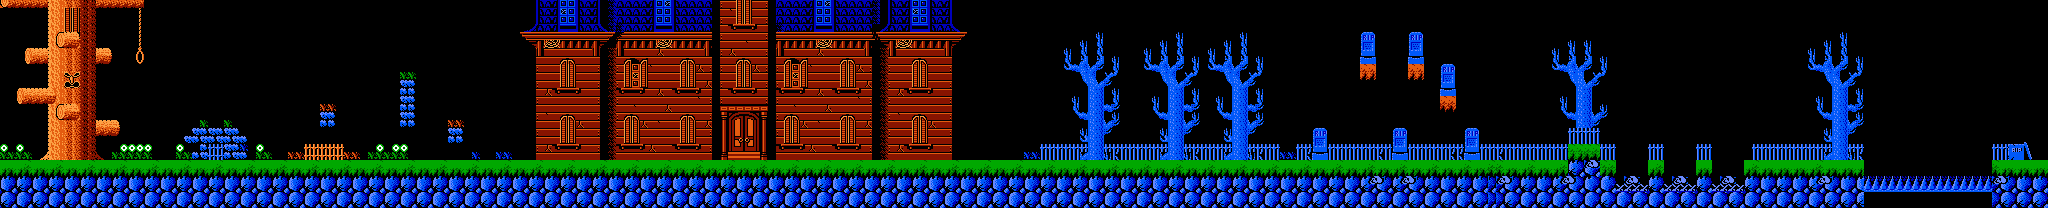

In [15]:
scr = makeScreen()
scr.Save(picPath+"scr0.png")
Image(filename=picPath+"scr0.png")